# Distracted Driver Recognition

### Project Overview

Distracted drivers contribute to more than 3000 road accidents per year. Analysis of figures from the Department for Transport (DfT) found that drivers who had been distracted from the task at hand were involved in 3,070 accidents during 2018. Unfortunately, those crashes led to a total of 93 deaths.

According to the organisation, 92 serious accidents involved mobile phone use as a contributing factor, with 25 fatal accidents involving the use of a mobile phone. However, drivers also need to be aware of other in-car systems such as satellite navigation the radio. Passengers and pets were also earmarked as potential distractions.

This report details the steps taken to develop a machine learning model to identify photographs of distracted driving behaviours. A real-life applictaion for this machine-learning model would be making an assessment of driver behaviour at the time that their image is captured (for example, whilst speeding) allowing for police to determine if their crime had contributory factors and should carry a harsher sentance.  

### Objective

Given a dataset of 2D dashboard camera images, containing both safe and unsafe behaviours, a convolutional neural network (CCN) was developed to classify each driver's behaviour and determine if they are driving attentively, wearing their seatbelt etc. or if they were engaging in unsafe, distracted behaviours that may result in injury or even death. 
For development of the deep-learning algorithm, the following steps were carried out: 
1.	Download and pre-process the driver images
2.	Build and train a model to classify the driver images
3.	Test the model and further improve the model (if required)



### Data Exploration

This project utilises a Kaggle competition dataset (State Farm Driver Detection – "Can computer vision spot distracted drivers?") (https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview)

This dataset is used for training and evaluating the model. The dataset includes 102,150 images of drivers that are separated into 10 categories which are labelled as follows, and shown below:

•	c0: safe driving  
•	c1: texting - right  
•	c2: talking on the phone - right  
•	c3: texting - left  
•	c4: talking on the phone – left  
•	c5: operating the radio  
•	c6: drinking  
•	c7: reaching behind  
•	c8: hair and makeup  
•	c9: talking to passenger  
![Distracted Driving Categories](Imgs/Image.png)

The dataset is split into train and test sets. The train set contains 22,424 images and the test set contains 79,726 images. All the images have the same resolution of 640×480 pixels. The class and the driver ID are specified for each image in the training data (driver ID specifies which driver is on the image). There are 26 different drivers in the dataset. 
 All the training and test images belong to the 10 categories shown above. The images are coloured and have 640 x 480 pixels each. 

### Import Libraries

In [2]:
import os
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.utils import np_utils
from keras.preprocessing import image 
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image     

from tqdm import tqdm

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

### Check Training Image Data

In [3]:
#read the project data .csv file into a dataframe
df = pd.read_csv(r"C:\Users\UK19759\OneDrive - Nissan Motor Corporation\Desktop\Machine Learning\state-farm-distracted-driver-detection\driver_imgs_list.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [5]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
df['classname']

0        c0
1        c0
2        c0
3        c0
4        c0
         ..
22419    c9
22420    c9
22421    c9
22422    c9
22423    c9
Name: classname, Length: 22424, dtype: object

In [7]:
df.describe().transpose()

,count,unique,top,freq
subject,22424,26,p021,1237
classname,22424,10,c0,2489
img,22424,22424,img_44733.jpg,1


### Implementation

The class distribution for this dataset is relatively uniform, as can be seen from using the .countplot function. If it had not been uniform, a preferred method would be to use a separate binary classification model for class individually then average the final evaluation of the classification approach. 

<AxesSubplot:xlabel='classname', ylabel='count'>

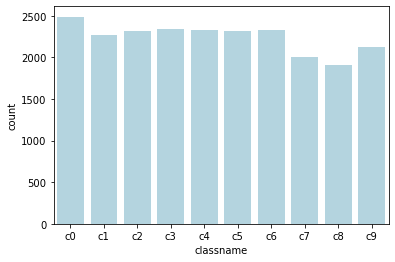

In [8]:
#check no. of instances per label using countplot to check that the problem is evenly distributed
sns.countplot(data=df,x='classname',color = "lightblue")

### Define the Train, Test and Model Directories

In [9]:
TEST_DIR = os.path.join(os.getcwd(),r"C:\Users\UK19759\OneDrive - Nissan Motor Corporation\Desktop\Machine Learning\state-farm-distracted-driver-detection\imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),r"C:\Users\UK19759\OneDrive - Nissan Motor Corporation\Desktop\Machine Learning\state-farm-distracted-driver-detection\imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")

if not os.path.exists(TEST_DIR):
    print("Testing data does not exist")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exist")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exist")
    os.makedirs(MODEL_PATH)
    print("Model path created")

In [10]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)
CSV_FILES_DIR = os.path.join(os.getcwd(),"csv_files")
if not os.path.exists(CSV_FILES_DIR):
    os.makedirs(CSV_FILES_DIR)
    
create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")

data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

### Check Training Data

In [11]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

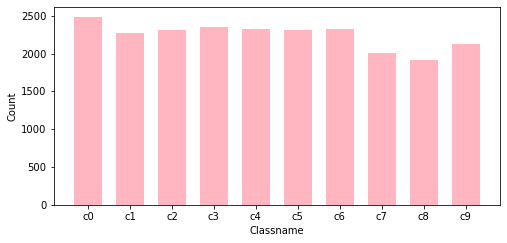

In [12]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(8,8))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=10)
plt.yticks(size=10)

ay.bar(x, y, width, color = 'lightpink')

plt.xlabel('Classname',size=10)
plt.ylabel('Count',size=10)

plt.show()

In [13]:
data_test.head()

,FileName,ClassName
0,C:\Users\UK19759\OneDrive - Nissan Motor Corpo...,test
1,C:\Users\UK19759\OneDrive - Nissan Motor Corpo...,test
2,C:\Users\UK19759\OneDrive - Nissan Motor Corpo...,test
3,C:\Users\UK19759\OneDrive - Nissan Motor Corpo...,test
4,C:\Users\UK19759\OneDrive - Nissan Motor Corpo...,test


### Data Pre-processing

In [14]:
#convert labels to numerical values 
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c6': 0, 'c0': 1, 'c7': 2, 'c3': 3, 'c4': 4, 'c8': 5, 'c1': 6, 'c5': 7, 'c2': 8, 'c9': 9}


In [15]:
#convert class vector to binary class matrix
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


In [16]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.25,random_state=0)

### Data Preparation

1) Convert all the train and test images to the same size   
2) Standardise the flattened image vector

In [17]:
def path_to_tensor(img_path):
    # loads image as PIL.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image type to 3D tensor with shape (64, 64, 3)
    tens_img = image.img_to_array(img)
    # convert 3D tensor to 4D with shape (1, 64, 64, 3) 
    return np.expand_dims(tens_img, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 16818/16818 [02:12<00:00, 127.01it/s]


In [19]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 5606/5606 [00:35<00:00, 158.48it/s]


## Defining Model Architecture

### Convolutional Neural Network (CNN)
CNNs are a type of Artificial Neural Networks. CNNs are mostly used for the analysis of visual data and assume that the inputs are structured data (commonly represented as gray-scale or RGB images, such as those within the Distracted Driver dataset), which allow us to encode certain properties into the architecture. These then make the forward function more efficient to implement and reduce the number of parameters within the network.

![CNN](Imgs/Cat1.png)

### Convolutional Layer 
The Convolutional Layer is the core of the Convolutional Neural Network architecture. Convolution is the application of a filter to an input that results in activation. Repeated application of the same filter to an input results in a map of activations called a feature map. Each filter creates its own feature map and the number of filters specifies the depth of the layer. 

The main parameters of the Convolutional layer are:   
•	Kernel Size - Specifies the dimension of convolution mask.    
•	Filters - Specifies the number of filters and depth of output.  
•	Strides - Specifies how much should we shift the convolution filter after each operation.     
### Pooling Layer
 The Pooling Layer compresses the information propagated to the following level of the network, therefore reducing the number of parameters and computational complexity. 
### Dense (ReLU) Layer
The rectified linear activation function is a linear function that will output the input directly if it is positive, otherwise, it will output zero.
### Dense (Softmax) Layer
The Softmax layer is usually used as the last layer in a mutually exclusive classification task, where the output vector is to be presented as the probability distribution that the input belongs to a particular class. It takes the Softmax function as an input vector of real numbers and normalises it into a probability distribution.


In [20]:
model = Sequential()
# Convolutional & Pooling Layers
model.add(Conv2D(filters=4, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2)) #Maxpool
model.add(Dropout(0.5))
model.add(Flatten())

# Dense layer
model.add(Dense(100, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 4)         52        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        528       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 16)         0

In [2]:
#plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

## Compile & Train Model

For this multi-class problem, the rmsprop optimizer and categorical crossentropy loss string paramater will be used. This restricts the oscillations in the vertical direction and selects a single category (out of many) as the output. 
A low epoch value will be used (epoch=10) to avoid unneccsessarily long training times, should the model be inaccurate. 

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]
epochs = 10
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=epochs, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/10
419/421 [============================>.] - ETA: 0s - loss: 1.9962 - accuracy: 0.2781
Epoch 00001: val_accuracy improved from -inf to 0.59971, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-01-0.60.hdf5
421/421 [==============================] - 10s 23ms/step - loss: 1.9947 - accuracy: 0.2785 - val_loss: 1.3616 - val_accuracy: 0.5997
Epoch 2/10
419/421 [============================>.] - ETA: 0s - loss: 1.4019 - accuracy: 0.5173
Epoch 00002: val_accuracy improved from 0.59971 to 0.76168, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-02-0.76.hdf5
421/421 [==============================] - 11s 27ms/step - loss: 1.4010 - accuracy: 0.5178 - val_loss: 0.8994 - val_accuracy: 0.7617
Epoch 3/10
420/421 [============================>.] - ETA: 0s - loss: 1.1191 - accuracy: 0.6180
Epoch 00003: val_accuracy improved from 0.76168 to 0.83928, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-03-

### Model Performance Graph

Training vs Validation and Training Accuracy vs Validation Accuracy were plotted. The model should be complex enough to capture relevant information in the training data, but avoid overfitting. 

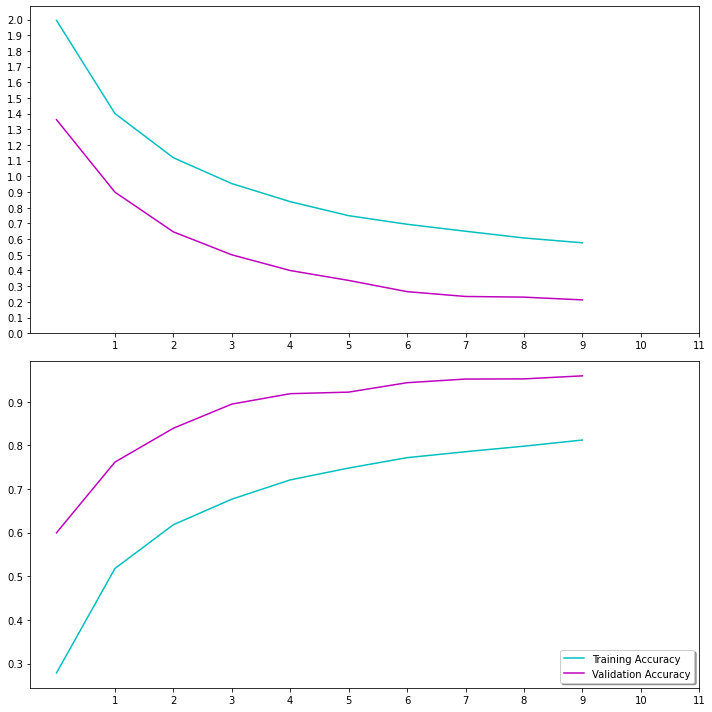

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(model_history.history['loss'], color='c', label="Training Loss")
ax1.plot(model_history.history['val_loss'], color='m', label="Validation Loss")
ax1.set_xticks(np.arange(1, 12, 1))
ax1.set_yticks(np.arange(0, 2.1, 0.1))

ax2.plot(model_history.history['accuracy'], color='c', label="Training Accuracy")
ax2.plot(model_history.history['val_accuracy'], color='m',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 12, 1))

legend = plt.legend(loc='lower right', shadow=True)
plt.tight_layout()
plt.show()

The graphs show that the model is too simple and doesn't converge quickly enough. The complexity of the hyperparameters will be increased (increase filter values) and more epochs (20) added to allow the model more time to improve. 

In [24]:
model_two = Sequential()
# Convolutional & Pooling Layers
model_two.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model_two.add(MaxPooling2D(pool_size=2)) #Maxpool
model_two.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model_two.add(MaxPooling2D(pool_size=2)) #Maxpool
model_two.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model_two.add(MaxPooling2D(pool_size=2)) #Maxpool
model_two.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model_two.add(MaxPooling2D(pool_size=2)) #Maxpool
model_two.add(Dropout(0.5))
model_two.add(Flatten())

# Dense Layers
model_two.add(Dense(100, activation='relu', kernel_initializer='glorot_normal'))
model_two.add(Dropout(0.5))
model_two.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

In [25]:
model_two.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]
epochs =20
model_two_history = model_two.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=epochs, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/20
421/421 [==============================] - ETA: 0s - loss: 1.4734 - accuracy: 0.4669
Epoch 00001: val_accuracy improved from -inf to 0.79379, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-01-0.79.hdf5
421/421 [==============================] - 55s 129ms/step - loss: 1.4734 - accuracy: 0.4669 - val_loss: 0.6395 - val_accuracy: 0.7938
Epoch 2/20
421/421 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.8012
Epoch 00002: val_accuracy improved from 0.79379 to 0.94363, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-02-0.94.hdf5
421/421 [==============================] - 54s 128ms/step - loss: 0.5923 - accuracy: 0.8012 - val_loss: 0.2499 - val_accuracy: 0.9436
Epoch 3/20
421/421 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.9005
Epoch 00003: val_accuracy improved from 0.94363 to 0.94417, saving model to C:\Users\UK19759\Machine Learning\model\self_trained\distracted-0

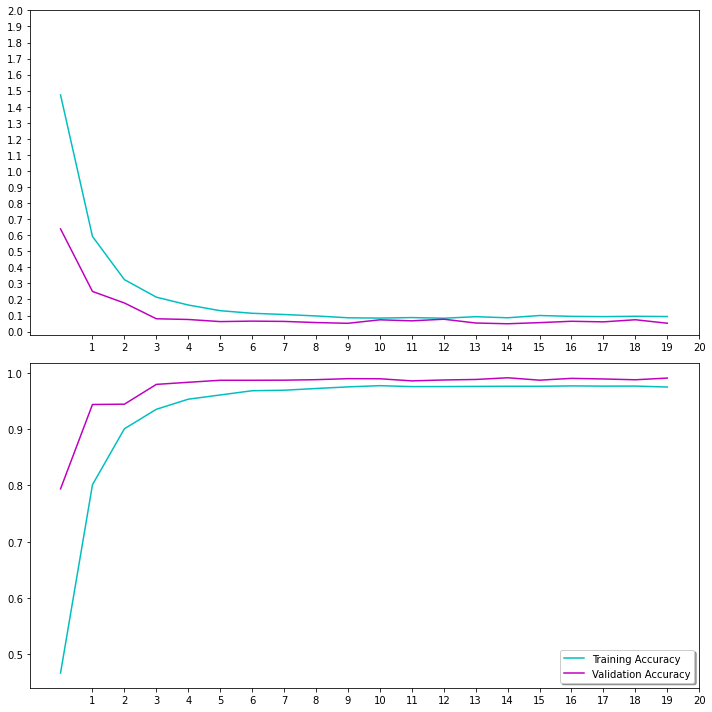

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(model_two_history.history['loss'], color='c', label="Training Loss")
ax1.plot(model_two_history.history['val_loss'], color='m', label="Validation Loss")
ax1.set_xticks(np.arange(1, 21, 1))
ax1.set_yticks(np.arange(0, 2.1, 0.1))

ax2.plot(model_two_history.history['accuracy'], color='c', label="Training Accuracy")
ax2.plot(model_two_history.history['val_accuracy'], color='m',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 21, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

The model now converges much quicker and remains steady at around epoch 8, indicating that this model is far more accruate. Each epoch took approximately five times as long to run and double the number were required, requiring far more computing power, however it provides a far more reliable alogorithm. 

### Model Analysis

The performance of the learning algorithm can be shown in a confusion matrix, which gives a count of the True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN) predictions of a classifier.
This makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). Combining this with a heatmap gives an indication of the scale of the mislabeling. 

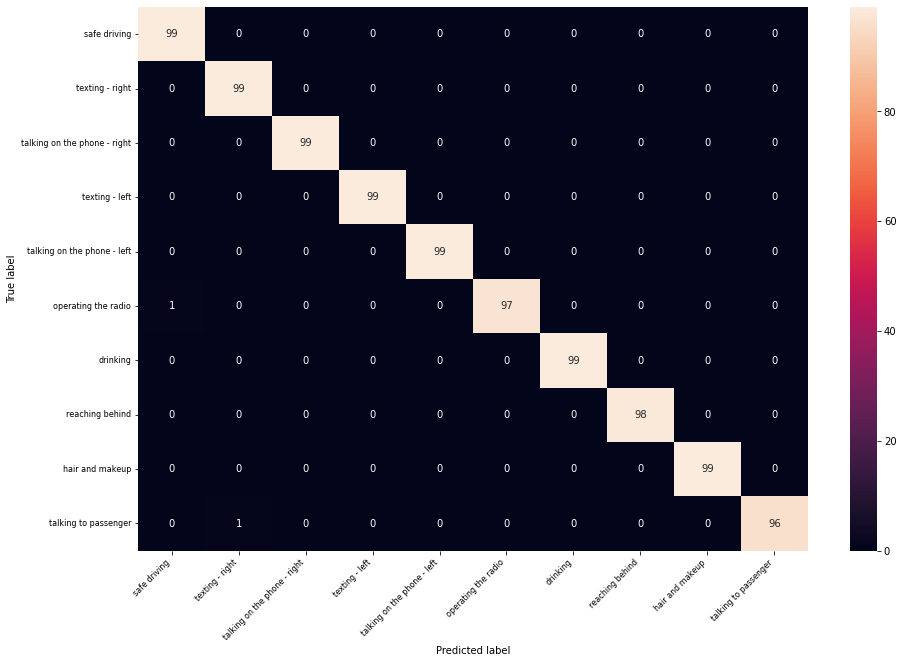

In [27]:
# function for confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,8), fontsize=8):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("CM values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig
# function for heatmap
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions 
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape
# use numpy zeros function    
    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    heatmap = print_confusion_matrix(c, class_names, figsize=(15,10), fontsize=8)
#include class names to make CM more readable
class_names = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 
               'hair and makeup', 'talking to passenger']

ypred = model_two.predict(valid_tensors)
print_heatmap(ytest,ypred,class_names)

The confusion matrix indicates a very high degree of accuracy, with very few false positives and no false negatives. 

### Accuracy, Precision & Recall of Model

Accuracy - The ratio of correctly predicted observation to the total observations.  

Precision – The ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate.   

Recall - The ratio of correctly predicted positive observations to the all observations in actual class.  

F1 score - The weighted average of Precision and Recall, taking both false positives and false negatives into account.   

In [28]:
ypred_class = np.argmax(ypred,axis=1)
ytest = np.argmax(ytest,axis=1)

#accuracy ratio
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)

# precision ratio
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)

# recall ratio
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)

# f1 score
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.990546
Precision: 0.990598
Recall: 0.990546
F1 score: 0.990541


### Check model on Test Images

In [29]:
BASE_MODEL_PATH = os.path.join(os.getcwd(),"model")
TEST_DIR = os.path.join(os.getcwd(),"csv_files","test.csv")
PREDICT_DIR = os.path.join(os.getcwd(),"pred_dir")
JSON_DIR = os.path.join(os.getcwd(),"json_files")
if not os.path.exists(PREDICT_DIR):
    os.makedirs(PREDICT_DIR)
else:
    shutil.rmtree(PREDICT_DIR)
    os.makedirs(PREDICT_DIR)
if not os.path.exists(JSON_DIR):
    os.makedirs(JSON_DIR)

BEST_MODEL = os.path.join(BASE_MODEL_PATH,"self_trained","distracted-08-0.99.hdf5") 
model = load_model(BEST_MODEL)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

In [30]:
data_test = pd.read_csv(os.path.join(TEST_DIR))
#test on only 10000 images as loading the all test images requires 8gb RAM
data_test = data_test[:10000] 
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FileName   10000 non-null  object
 1   ClassName  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [31]:
ImageFile.LOAD_TRUNCATED_IMAGES = True  
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5

100%|██████████| 10000/10000 [01:33<00:00, 106.61it/s]


In [32]:
# Return maximum predictions
ypred_test = model.predict(test_tensors,verbose=1)
ypred_class = np.argmax(ypred_test,axis=1)

id_labels = dict()
for class_name, idx in labels_id.items():
    id_labels[idx] = class_name
print(id_labels)

for j in range(data_test.shape[0]):
    data_test.iloc[j,1] = id_labels[ypred_class[j]]

313/313 [==============================] - 9s 28ms/step
{0: 'c6', 1: 'c0', 2: 'c7', 3: 'c3', 4: 'c4', 5: 'c8', 6: 'c1', 7: 'c5', 8: 'c2', 9: 'c9'}


### Image Classification
In order to view the results of the modelling, a human readable and understandable classname will be added to the image files. 

In [33]:
import json
class_name = dict()
# Define new classnames
class_name["c0"] = "Safe_Driving"
class_name["c1"] = "Texting_Right"
class_name["c2"] = "Talking_Phone_Right"
class_name["c3"] = "Texting_Left"
class_name["c4"] = "Talking_Phone_left"
class_name["c5"] = "Operating_Radio"
class_name["c6"] = "Drinking"
class_name["c7"] = "Reaching_Behind"
class_name["c8"] = "Hair_And_Makeup"
class_name["c9"] = "Talking_To_Passenger"

with open(os.path.join(JSON_DIR,'class_name_map.json'),'w') as secret_input:
    json.dump(class_name,secret_input,indent=4,sort_keys=True)

In [34]:
with open(os.path.join(JSON_DIR,'class_name_map.json')) as secret_input:
    info = json.load(secret_input)
# Copy files
for j in range(data_test.shape[0]):
    new_name = data_test.iloc[j,0].split("/")[-1].split(".")[0]+"_"+info[data_test.iloc[j,1]]+".jpg"
    shutil.copy(data_test.iloc[j,0],os.path.join(PREDICT_DIR,new_name))
    
data_test.to_csv(os.path.join(os.getcwd(),"csv_files","short_test_result.csv"),index=False)

### Conclusion

Following review of the test images, it is clear that many of the images have been mis-labelled and some of the classes are more problematic than others. In particular, those images where the participants were wearing glasses/sunglasses and whose hands and arms cross their body are easily misconstrued (i.e. sunglasses were confused for a mobile phone, see fig below). 
![Glasses](Imgs/Glasses.jpg)

In addition, those images where a participant has been labelled as talking to a passenger may simply be considering the environment around them and are not distracted at all. 

To improve the result, a larger training set could be used and the categories could be futher segragated to focus on expanding and identifying the problematic classes. Subtle human behaviours that influence the result (i.e. the driver smiling or with their mouth open suggests talking to a passenger, an extended arm but eyes on the road may indicating adjusting air vents rather than the radio) and these were not included in the initial classification. Additionally, more images that include accessories such a glasses, jewellery, hats etc. would allow for less confusion.  

### References

*Aditya Sharma. (2017, December 5). Convolutional Neural Networks in Python with Keras. Datacamp.*

*Demeng Feng. (2019). Machine Learning Techniques for Distracted Driver Detection.*

*Goodfellow lan, Bengio Yoshua, C. A. (2016). Deep Learning - Ian Goodfellow, Yoshua Bengio, Aaron Courville - Google Books. In MIT Press.*

*Han, E. S., & goleman, daniel; boyatzis, Richard; Mckee, A. (2019). Pattern Recognition and Machine Learning by Christopher M. Bishop. In Journal of Chemical Information and Modeling (Vol. 53, Issue 9).*

*Kaggle. (2021). Kaggle: Your Home for Data Science. Website.*

*Lee, H., & Song, J. (2019). Introduction to convolutional neural network using Keras; An understanding from a statistician. Communications for Statistical Applications and Methods, 26(6). https://doi.org/10.29220/CSAM.2019.26.6.591*

*McDonald, A. D., Ferris, T. K., & Wiener, T. A. (2020). Classification of Driver Distraction: A Comprehensive Analysis of Feature Generation, Machine Learning, and Input Measures. Human Factors, 62(6). https://doi.org/10.1177/0018720819856454*

*Omerustaoglu, F., Sakar, C. O., & Kar, G. (2020). Distracted driver detection by combining in-vehicle and image data using deep learning. Applied Soft Computing Journal, 96. https://doi.org/10.1016/j.asoc.2020.106657*

*Raschka, S., & Mirjalili, V. (2006). Python Machine Learning (Second Edition). In John Wiley & Sons, Inc.*

*Renu Khandelwal. (2020, May 18). Convolutional Neural Network: Feature Map and Filter Visualization. TDS.*

*Rosen, T. (2017). Choosing the right estimator. Bsd.*